# Pressor Distributions
- Ruoyi Jiang
- July 19, 2019
- Evaluation of the different pressor combinations used in MIMIC

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(fasttime)

# RR analysis
library(epitools)

# ROC (and plotting)
library(boot)
library(pROC)

# imputation
library(randomForest)

# VIF analysis
library(car)

library(glmnet)
library(pls)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:boot’:

    logit

The following object is masked from ‘package:dplyr’:

    recode

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: foreach
Loaded glmnet 2.0-18


Attaching package: ‘glmnet’

The fo

In [75]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-apple-darwin18.5.0 (64-bit)
Running under: macOS Mojave 10.14.3

Matrix products: default
BLAS/LAPACK: /usr/local/Cellar/openblas/0.3.6_1/lib/libopenblasp-r0.3.6.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pls_2.7-1           glmnet_2.0-18       foreach_1.4.7      
 [4] Matrix_1.2-17       car_3.0-3           carData_3.0-2      
 [7] randomForest_4.6-14 pROC_1.15.3         boot_1.3-22        
[10] epitools_0.5-10     fasttime_1.0-2      ggplot2_3.2.0      
[13] tidyr_0.8.3         dplyr_0.8.1        

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3      tidyselect_0.2.5  repr_1.0.1        purrr_0.3.2      
 [5] haven_2.1.1       lattice_0.20-38   colorspace_1.4-1  vctrs_0.2.0      
 [9] htmltools_0.3.6   base64enc_0.1-3   rlang_0.4.0       pillar_1.4.0     
[13] f

In [2]:
### Plotting base_theme
base_theme <- function(){ theme_bw() + 
            theme(text=element_text(size=8)) +
            theme(plot.title=element_text(size=8)) +
            theme(plot.background=element_blank(),
                  panel.grid.major=element_blank(), 
                  panel.grid.minor=element_blank()) +
            theme(strip.background=element_blank(),
                  strip.text=element_text(size=7, face='bold')) +
            theme(axis.title=element_text(size=8, vjust=0.25),
                  axis.text.x=element_text(size=8, vjust=0.5, hjust=0.5),
                  axis.text.y=element_text(size=8)) +
            theme(legend.text=element_text(size=7),
                  legend.title=element_text(size=7),
                  legend.key.height=grid::unit(10, "points"), 
                  legend.key.width=grid::unit(10, "points"))}

### Load data and take quick peek at select "pressors"  (e.g. vent and central line)

In [3]:
pressors_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/pressors.csv')

In [4]:
dim(pressors_df)

[1] 227645     11

In [5]:
pressors_df %>%
    filter(pressor == "central_line_durations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
30584,central_line_durations,0,70.91667,2181-11-28 20:59:00,200001,NA,central_line_durations,2181-11-25 22:04:00,NA,NA
30585,central_line_durations,1,134.00000,2199-08-08 15:00:00,200003,NA,central_line_durations,2199-08-03 01:00:00,NA,NA
30586,central_line_durations,2,37.75000,2189-12-02 08:00:00,200009,NA,central_line_durations,2189-11-30 18:15:00,NA,NA
30587,central_line_durations,3,19.68333,2132-08-05 20:36:00,200010,NA,central_line_durations,2132-08-05 00:55:00,NA,NA
30588,central_line_durations,4,23.76667,2114-12-27 22:46:00,200021,NA,central_line_durations,2114-12-26 23:00:00,NA,NA
30589,central_line_durations,5,9.30000,2127-03-04 01:18:00,200024,NA,central_line_durations,2127-03-03 16:00:00,NA,NA


In [6]:
pressors_df %>%
    filter(pressor == "ventdurations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
189130,ventdurations,0,91.00000,2199-08-07 13:00:00,200003,NA,ventdurations,2199-08-03 18:00:00,NA,1
189131,ventdurations,1,14.83333,2159-09-04 03:50:00,200006,NA,ventdurations,2159-09-03 13:00:00,NA,1
189132,ventdurations,2,15.83333,2189-12-01 10:00:00,200009,NA,ventdurations,2189-11-30 18:10:00,NA,1
189133,ventdurations,3,3.00000,2188-08-06 04:00:00,200011,NA,ventdurations,2188-08-06 01:00:00,NA,1
189134,ventdurations,4,18.75000,2105-02-17 18:00:00,200014,NA,ventdurations,2105-02-16 23:15:00,NA,1
189135,ventdurations,5,83.00000,2138-03-21 09:00:00,200017,NA,ventdurations,2138-03-17 22:00:00,NA,1


In [7]:
pressors_df %>%
    group_by(pressor) %>%
    summarize(COUNT = n())

pressor,COUNT
<fct>,<int>
adenosinedurations,160
arterial_line_durations,30424
central_line_durations,38211
crrtdurations,5918
dobutaminedurations,1792
dopaminedurations,6524
epinephrinedurations,3126
isupreldurations,24
milrinonedurations,3600


### Available pressor (and other infusions) choices
- Make choices
- Quick check of dataset balancing

In [9]:
pressor_choices <- c("norepinephrinedurations", "dopaminedurations", 
                     "phenylephrinedurations", "vasopressindurations", 'epinephrinedurations', 'dobutaminedurations')

In [10]:
FANCY_PRESSOR_ORDER <- c("Norepinephrine", "Dopamine", "Phenylephrine", "Vasopressin", "Epinephrine", "Dobutamine")

In [11]:
FANCY_PRESSOR_DICT <- c(
'dopaminedurations' = 'Dopamine',
'norepinephrinedurations' = 'Norepinephrine',  
'phenylephrinedurations' = 'Phenylephrine',
"vasopressindurations" = "Vasopressin",
'epinephrinedurations' = "Epinephrine",
'dobutaminedurations' = "Dobutamine"
)

In [12]:
PLOT_DIR <- "~/Google Drive/vasopressors/figures_v2"

In [13]:
pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    filter((pressor == 'phenylephrinedurations' & duration_hours > 0.5) |
           (pressor == 'epinephrinedurations' & duration_hours > 0.5) |
           !(pressor %in% c('phenylephrinedurations', 'phenylephrinedurations'))
          ) %>%
    mutate(MORETHAN24HOURS = duration_hours > 24) %>%
    group_by(MORETHAN24HOURS, pressor) %>% 
    summarize(COUNT = n())

MORETHAN24HOURS,pressor,COUNT
<lgl>,<fct>,<int>
FALSE,dobutaminedurations,1412
FALSE,dopaminedurations,5422
FALSE,epinephrinedurations,2797
FALSE,norepinephrinedurations,19811
FALSE,phenylephrinedurations,26872
FALSE,vasopressindurations,2537
TRUE,dobutaminedurations,380
TRUE,dopaminedurations,1102
TRUE,epinephrinedurations,329


### Histograms of pressor durations for all 5 pressors of interest

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1254 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1254 rows containing non-finite values (stat_density).”

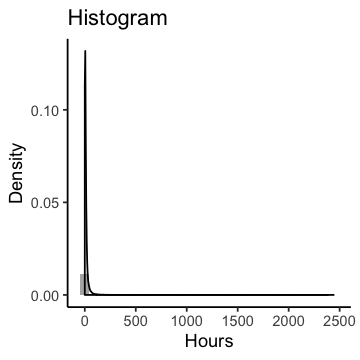

In [784]:
options(repr.plot.width=3, repr.plot.height=3)
p <- pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    mutate(DIFF = 
              difftime(fastPOSIXct(endtime), 
               fastPOSIXct(starttime), units="hours")) %>%
    ggplot(aes(x=DIFF)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic()
plot(p)

### Join with icustay metadata (pressors_df + lengthstay_df -> input_df)

In [14]:
lengthstay_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/length_stay.csv') %>%
    rename(icustarttime = START, icuendtime = END)

In [15]:
lengthstay_df %>% head()

X,icustay_id,icustarttime,icuendtime,DIFF
<int>,<int>,<fct>,<fct>,<dbl>
1,200001,2181-11-25 19:06:00,2181-11-28 20:00:00,72.90000
2,200003,2199-08-02 19:15:00,2199-08-08 15:00:00,139.75000
3,200006,2159-09-03 12:30:00,2159-09-04 17:00:00,28.50000
4,200007,2109-02-17 09:00:00,2109-02-18 09:15:00,24.25000
5,200009,2189-11-30 11:43:00,2189-12-02 13:00:00,49.28333
6,200010,2132-08-05 00:39:00,2132-08-05 21:17:00,20.63333


In [16]:
# filter by pressor and left join with lengthstay_df
input_df <- pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    filter((pressor == 'phenylephrinedurations' & duration_hours > 0.5) |
           (pressor == 'epinephrinedurations' & duration_hours > 0.5) |
           !(pressor %in% c('phenylephrinedurations', 'phenylephrinedurations'))
          ) %>%
    left_join(lengthstay_df, by = "icustay_id") %>%
    mutate(starttime = fastPOSIXct(starttime), endtime = fastPOSIXct(endtime), 
           icustarttime = fastPOSIXct(icustarttime), icuendtime = fastPOSIXct(icuendtime))

# Filters

#### Collapse pressor courses based on length of intervening time (<24 hrs)
- Any two courses with less than intervening 24 hours will be collapsed into a single course within an icustay

In [17]:
max_intervening_hrs <- 24

# find the intervening time between courses (endtime of next course - endtime of course - duration of course)
# then determine if that length of time is >24 or <24 and mark it with a 0 if true, else a 1
# use a cumsum to create a new id separating courses that are separated by more than >24

input_df <- input_df %>%
        group_by(icustay_id) %>%
        mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
        rowwise() %>%
        mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
        ungroup() %>%
        group_by(icustay_id) %>%
        mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)

In [626]:
# max_intervening_hrs <- 24

# # find the intervening time between courses (endtime of next course - endtime of course - duration of course)
# # then determine if that length of time is >24 or <24 and mark it with a 0 if true, else a 1
# # use a cumsum to create a new id separating courses that are separated by more than >24
# input_list <- list()
# for(pressor_choice in pressor_choices){
#     input_list[[pressor_choice]] <- input_df %>%
#         filter(pressor == pressor_choice) %>%
#         group_by(icustay_id) %>%
#         mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
#         rowwise() %>%
#         mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
#         ungroup() %>%
#         group_by(icustay_id) %>%
#         mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)
#     cat(pressor_choice, '\n')
# }

In [627]:
# input_df <- bind_rows(input_list, .id="pressor_choice")

- the combination of **continuous course** and **icustay_id** (e.g. 200024, 0 for first row) now defines each pressor course

- assign boolean assessments after <24 hour intervals between pressors are removed
    1. more or less than 24 hours of pressor duration?
    2. is this the first pressor course?
    3. are pressors administered <1 hr of the icustay?

In [18]:
# 1. more or less than 24 hours?
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(MORETHAN24HOURS = sum(duration_hours) > 24, 
           STATUS = if(sum(duration_hours) > 24){"MORETHAN24HOURS"}
           else if(sum(duration_hours) <= 24 & sum(duration_hours) > 6){"LESSTHAN24HOURS"}
           else if(sum(duration_hours) <= 6){"LESSTHAN6HOURS"}
               )

In [19]:
# 2. first pressor course? (groupby icustay, filter min starttime == starttime)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(FIRSTCOURSE = min(coursestarttime) == coursestarttime)

In [20]:
# 3. pressors within 1 hr of icustay_id? (groupby icustay, filter max starttime - unique icustarttime > 1)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(LESS1HOUR = difftime(min(coursestarttime), 
                         min(icustarttime)) < 1)

In [21]:
# grouped by icustay_id + continuous_course + separate_course
input_df %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS) %>%
    summarize(COUNT = n())

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,2329
FALSE,FALSE,TRUE,9274
FALSE,TRUE,FALSE,14663
FALSE,TRUE,TRUE,35471
TRUE,FALSE,FALSE,110
TRUE,FALSE,TRUE,316
TRUE,TRUE,FALSE,907
TRUE,TRUE,TRUE,1967
NA,FALSE,FALSE,149


In [22]:
# With filters grouped by icustay_id + continuous_course
input_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,COUNT
<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,1489
FALSE,FALSE,TRUE,1790
FALSE,TRUE,FALSE,8675
FALSE,TRUE,TRUE,6844
TRUE,FALSE,FALSE,68
TRUE,FALSE,TRUE,77
TRUE,TRUE,FALSE,588
TRUE,TRUE,TRUE,434
NA,FALSE,FALSE,105


### Introduce other predictor values for each course (like RACE, Diagnosis type) -> nonvitals_predictor_df

In [25]:
races <- c("ASIAN", "BLACK", "HISPANIC", "WHITE", "OTHER")

simplifyRace <- function(ethnicity){
    if(grepl("ASIAN", ethnicity)){return("ASIAN")}
    else if(grepl("BLACK", ethnicity)){return("BLACK")}
    else if(grepl("HISPANIC", ethnicity)){return("HISPANIC")}
    else if(grepl("WHITE", ethnicity)){return("WHITE")}
    else{return("OTHER")}
}

In [26]:
sepsis_regex <- c('SEPSIS', 'SEPTIC', 'CHOLANGITIS', 'UROSEPSIS')

infection_regex <- c('PNEUMONIA', 'INFECTION',  
  'CELULLITIS', 'FASCITIS', 'INFECTED', 'BACTER', 'PNEMONIA', 'ABSCESS', 'NEPHRITIS')

cardiac_regex <- c('HEART', 'CORONARY', 'VENTRICULAR')

simplifyDiagnosis <- function(diagnosis){
    if(any(sapply(sepsis_regex, function(x) grepl(x, diagnosis)))){return("SEPSIS")}
    else if(any(sapply(infection_regex, function(x) grepl(x, diagnosis)))){return("INFECTION")}
    else if(any(sapply(cardiac_regex, function(x) grepl(x, diagnosis)))){return("CARDIAC")}
    else{return("OTHER DIAGNOSIS")}
}

In [27]:
icustays_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/icustays.csv')

In [28]:
admissions_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/admissions.csv')

In [29]:
patients_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/patients.csv')

In [30]:
intub_df <- pressors_df %>%
    filter(pressor == "ventdurations") 

cvc_df <- pressors_df %>%
    filter(pressor == "central_line_durations") 

In [31]:
nonvitals_predictor_df <- icustays_df %>%
    select(hadm_id, icustay_id, first_careunit, last_careunit) %>%
    left_join(admissions_df, by = 'hadm_id') %>%
    left_join(patients_df, by = 'subject_id') %>%
    mutate(intub = icustay_id %in% intub_df$icustay_id, cvc = icustay_id %in% cvc_df$icustay_id) %>%
    mutate(deathtime = fastPOSIXct(deathtime), admittime = fastPOSIXct(admittime), dob = fastPOSIXct(dob)) %>%
    mutate(age = difftime(admittime, dob, units="weeks")/52.25, 
           age_cohort = as.numeric(round(age, digits = -1))) %>% 
    rowwise() %>%
    mutate(simple_race = simplifyRace(ethnicity)) %>%
    mutate(simple_diagnosis = simplifyDiagnosis(diagnosis))

### Mortality filter
- Remove patients who stopped using pressors because death (merge with pressors_df by icustay_id, filter if pressor course end time == or is close to deathtime)
- Also quantify some unusual cases of death documentation

In [35]:
#NA means the stay did not end in death
#ICUSTAYS where patient was discharged after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, dischtime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,40
TRUE,6422
NA,55070


In [36]:
#NA means the stay did not end in death
#ICUSTAYS where patient was admitted after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, admittime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,6384
TRUE,78
NA,55070


In [37]:
#Examples (admitted after death)
nonvitals_predictor_df  %>%
    filter(difftime(deathtime, admittime, units = "mins") < 0) %>%
    head(5)

hadm_id,icustay_id,first_careunit,last_careunit,X.x,row_id.x,subject_id,admittime,dischtime,deathtime,⋯,dod,dod_hosp,dod_ssn,expire_flag,intub,cvc,age,age_cohort,simple_race,simple_diagnosis
<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dttm>,<fct>,<dttm>,⋯,<fct>,<fct>,<fct>,<int>,<lgl>,<lgl>,<drtn>,<dbl>,<chr>,<chr>
102631,246694,CSRU,CSRU,456,237,181,2153-10-12 05:49:00,2153-10-12 06:29:00,2153-10-12 02:29:00,⋯,2153-10-12,2153-10-12,2153-10-12,1,FALSE,FALSE,65.12757082 weeks,70,WHITE,OTHER DIAGNOSIS
138015,298263,NICU,NICU,1911,1640,1334,2137-09-02 10:43:00,2137-09-02 12:00:00,2137-09-02 08:00:00,⋯,2137-09-02,2137-09-02,,1,TRUE,FALSE,0.00167654 weeks,0,WHITE,OTHER DIAGNOSIS
181430,291798,SICU,SICU,1970,1699,1381,2189-01-02 09:25:00,2189-01-02 12:00:00,2189-01-02 07:00:00,⋯,2189-01-02,2189-01-02,2189-01-02,1,TRUE,FALSE,81.36049404 weeks,80,WHITE,OTHER DIAGNOSIS
187482,213831,MICU,MICU,693,644,516,2197-07-31 16:18:00,2197-07-31 01:10:00,2197-07-30 21:10:00,⋯,2197-07-31,2197-07-31,2197-07-31,1,FALSE,FALSE,70.88679654 weeks,70,OTHER,OTHER DIAGNOSIS
190088,293048,CCU,CCU,3624,3447,2858,2108-09-25 11:29:00,2108-09-25 12:00:00,2108-09-25 08:00:00,⋯,2108-09-25,2108-09-25,2108-09-25,1,TRUE,FALSE,82.42418356 weeks,80,WHITE,OTHER DIAGNOSIS


In [38]:
# Icustays where patients received pressors after death (TRUE)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    mutate(STOPMORTALITY = difftime(deathtime, endtime, units = "mins")) %>% 
    group_by(STOPMORTALITY < 0) %>%
    summarize(COUNT = length(unique(icustay_id)))

STOPMORTALITY < 0,COUNT
<lgl>,<int>
FALSE,3442
TRUE,696
NA,13387


### Test out some mortality filters

In [39]:
### if I do not ignore for unusual cases (pressors after death)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,19042
TRUE,4309
NA,45052


In [40]:
### if I do ignore these unusual cases
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY > 0 &  STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,23123
TRUE,228
NA,45052


### Create filters for mortality: input_df -> input_death_df

In [41]:
# # ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# # do not remove unusual cases
# input_death_df <- input_df %>%
#     ungroup() %>%
#     left_join(nonvitals_predictor_df, by = "icustay_id") %>%
#     group_by(icustay_id, continuous_course, pressor) %>%
#     mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
#     mutate(STOPMORTALITY = !(!(STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

In [42]:
# ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# remove unusual cases
input_death_df <- input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = !(!(STOPMORTALITY > 0 &  STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

### Exclude NICU (all NICU was already excluded by pressor usage): : input_death_df -> input_death_df

In [43]:
input_death_df %>%
    mutate(NICUSTAY = first_careunit == "NICU") %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, STOPMORTALITY, MORETHAN24HOURS, NICUSTAY) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,STOPMORTALITY,MORETHAN24HOURS,NICUSTAY,COUNT
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,FALSE,1482
FALSE,FALSE,FALSE,FALSE,TRUE,5
FALSE,FALSE,FALSE,TRUE,FALSE,1756
FALSE,FALSE,FALSE,TRUE,TRUE,22
FALSE,FALSE,TRUE,FALSE,FALSE,2
FALSE,FALSE,TRUE,TRUE,FALSE,12
FALSE,TRUE,FALSE,FALSE,FALSE,8572
FALSE,TRUE,FALSE,FALSE,TRUE,87
FALSE,TRUE,FALSE,TRUE,FALSE,6713


In [44]:
input_death_df <- input_death_df %>%
    filter(first_careunit != "NICU")

### Use filters, clean predictors: input_death_df -> output_df

In [45]:
output_df <- input_death_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(course_id) %>%
    mutate(starttime = min(starttime), endtime = max(endtime)) %>%
    filter(!LESS1HOUR, FIRSTCOURSE, !STOPMORTALITY) 

In [47]:
# collapse so each row is a course_id
output_df <- output_df %>%
    group_by(course_id) %>%
    summarize(
            PATIENT = unique(subject_id)[1],
            STATUS = unique(STATUS)[1], 
            MORETHAN24HOURS = unique(MORETHAN24HOURS)[1], 
            simple_diagnosis = unique(simple_diagnosis)[1], 
            simple_race = unique(simple_race)[1], 
            age = unique(age)[1], 
            age_cohort = unique(age_cohort)[1], 
            cvc = unique(cvc)[1],
            intub = unique(intub)[1],
            first_careunit = unique(first_careunit)[1],
            gender = unique(gender)[1],
            icustay_id = unique(icustay_id)[1],
            starttime = min(starttime), 
            endtime = max(endtime),
            pressor = paste(unique(pressor), collapse=",")
    ) %>% 
    mutate(duration = difftime(endtime, 
                       starttime, units="hours"))

In [48]:
dim(output_df)

[1] 15285    17

In [49]:
output_df %>%
    group_by(pressor) %>%
    summarize(COUNT = n())

pressor,COUNT
<chr>,<int>
dobutaminedurations,164
"dobutaminedurations,dopaminedurations",120
"dobutaminedurations,dopaminedurations,epinephrinedurations",3
"dobutaminedurations,dopaminedurations,epinephrinedurations,norepinephrinedurations",4
"dobutaminedurations,dopaminedurations,epinephrinedurations,norepinephrinedurations,phenylephrinedurations,vasopressindurations",3
"dobutaminedurations,dopaminedurations,epinephrinedurations,norepinephrinedurations,vasopressindurations",2
"dobutaminedurations,dopaminedurations,epinephrinedurations,phenylephrinedurations",2
"dobutaminedurations,dopaminedurations,norepinephrinedurations",67
"dobutaminedurations,dopaminedurations,norepinephrinedurations,phenylephrinedurations",27


### If more than 1 pressor is used, MORETHAN24HOURS is TRUE

In [50]:
output_df <- output_df %>%
    rowwise() %>%
    mutate(RESPONSE = MORETHAN24HOURS | grepl(",", pressor))

# Analysis

### For text, description of meta-data

In [52]:
length(unique(output_df$PATIENT))

[1] 13527

In [53]:
length(unique(output_df$icustay_id))

[1] 15175

In [54]:
# minimum age
min(output_df$age, na.rm=TRUE)

[1] 15.15073

In [55]:
dim(output_df)

[1] 15285    18

In [56]:
output_df %>%
    group_by(STATUS) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

STATUS,COUNT
<chr>,<int>
LESSTHAN24HOURS,5064
LESSTHAN6HOURS,3508
MORETHAN24HOURS,6713


In [64]:
output_df %>%
    group_by(STATUS, pressor) %>%
    summarize(COUNT = length(unique(PATIENT))) %>%
    filter(!grepl(",", pressor))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

STATUS,pressor,COUNT
<chr>,<chr>,<int>
LESSTHAN24HOURS,dobutaminedurations,61
LESSTHAN24HOURS,dopaminedurations,396
LESSTHAN24HOURS,epinephrinedurations,128
LESSTHAN24HOURS,norepinephrinedurations,929
LESSTHAN24HOURS,phenylephrinedurations,2304
LESSTHAN24HOURS,vasopressindurations,15
LESSTHAN6HOURS,dobutaminedurations,41
LESSTHAN6HOURS,dopaminedurations,419
LESSTHAN6HOURS,epinephrinedurations,95


In [65]:
output_df %>%
    group_by(STATUS == "LESSTHAN6HOURS") %>%
    summarize(COUNT = length(unique(PATIENT))) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

"STATUS == ""LESSTHAN6HOURS""",COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,10513,0.7541066
TRUE,3428,0.2458934


In [66]:
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS", cvc) %>%
    summarize(COUNT = length(unique(PATIENT))) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1492,0.1396742
FALSE,TRUE,9190,0.8603258
TRUE,FALSE,812,0.2353623
TRUE,TRUE,2638,0.7646377


In [72]:
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1527,0.1296595
FALSE,TRUE,10250,0.8703405
TRUE,FALSE,817,0.2328962
TRUE,TRUE,2691,0.7671038


In [67]:
output_df %>%
    group_by(STATUS == "MORETHAN24HOURS") %>%
    summarize(COUNT = length(unique(PATIENT))) %>% 
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

"STATUS == ""MORETHAN24HOURS""",COUNT,FREQ
<lgl>,<int>,<dbl>
FALSE,8105,0.5697315
TRUE,6121,0.4302685


In [71]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1798,0.20975268
FALSE,TRUE,6774,0.79024732
TRUE,FALSE,546,0.08133472
TRUE,TRUE,6167,0.91866528


In [68]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = length(unique(PATIENT))) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1769,0.21557397
FALSE,TRUE,6437,0.78442603
TRUE,FALSE,539,0.08724506
TRUE,TRUE,5639,0.91275494


In [78]:
# single pressor lasting less than 24 hrs
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", SINGLE = !grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    ungroup() %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,SINGLE,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1416,0.09263984
FALSE,TRUE,7156,0.46817141
TRUE,FALSE,3807,0.24906771
TRUE,TRUE,2906,0.19012103


In [79]:
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS", SINGLE = !grepl(",", pressor)) %>%
    summarize(COUNT = n()) %>% 
    ungroup() %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,SINGLE,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,4984,0.32607131
FALSE,TRUE,6793,0.44442264
TRUE,FALSE,239,0.01563624
TRUE,TRUE,3269,0.21386981


In [69]:
output_df %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS", pressor) %>%
    summarize(COUNT = length(unique(PATIENT))) %>% 
    group_by(pressor) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>% filter(RESPONSE) %>% filter(!grepl(",", pressor))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,pressor,COUNT,FREQ
<lgl>,<chr>,<int>,<dbl>
TRUE,dobutaminedurations,41,0.2515337
TRUE,dopaminedurations,419,0.3681898
TRUE,epinephrinedurations,95,0.3784861
TRUE,norepinephrinedurations,678,0.2734974
TRUE,phenylephrinedurations,1995,0.3498772
TRUE,vasopressindurations,12,0.2352941


In [70]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", pressor) %>%
    summarize(COUNT = length(unique(PATIENT))) %>% 
    group_by(pressor) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>% filter(!RESPONSE) %>% filter(!grepl(",", pressor))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,pressor,COUNT,FREQ
<lgl>,<chr>,<int>,<dbl>
FALSE,dobutaminedurations,102,0.6219512
FALSE,dopaminedurations,806,0.7039301
FALSE,epinephrinedurations,222,0.8880000
FALSE,norepinephrinedurations,1575,0.6322762
FALSE,phenylephrinedurations,4263,0.7465849
FALSE,vasopressindurations,27,0.5294118


#### All courses

Warning message:
“Removed 678 rows containing non-finite values (stat_density).”

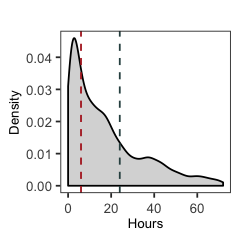

In [83]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(',', pressor)) %>%
    ggplot(aes(x=duration)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        xlim(0, 72) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F")
plot(p)

In [84]:
pdf(file.path(PLOT_DIR, "histo_durations.pdf"), 2, 2)
plot(p)
dev.off()

Warning message:
“Removed 678 rows containing non-finite values (stat_density).”

pdf 
  2

#### Courses involving any of these pressors

Warning message:
“Removed 678 rows containing non-finite values (stat_density).”

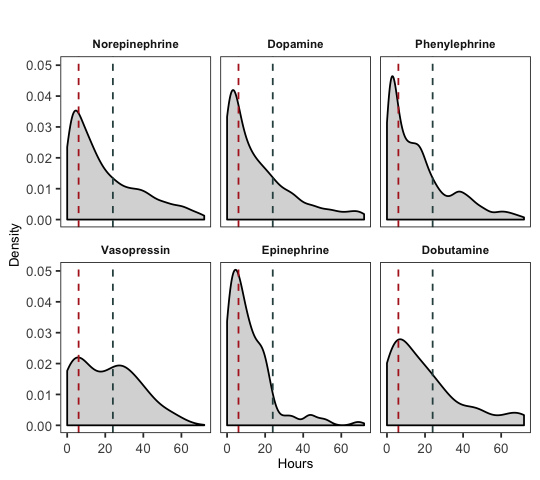

In [172]:
options(repr.plot.width=4.5, repr.plot.height=4)
p <- output_df %>%
    filter(!grepl(',', pressor)) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=duration)) +
        base_theme() +
        #geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6, fill="gray")+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="",x="Hours", y = "Density")+
        xlim(0, 72) +
        geom_vline(xintercept = 6, linetype= "dashed", color="firebrick") +
        geom_vline(xintercept = 24, linetype= "dashed", color="#2F4F4F") +
        facet_wrap(. ~fancy_pressor, nrow=2, ncol=3)
plot(p)

In [173]:
pdf(file.path(PLOT_DIR, "histo_individual_durations.pdf"), 4.5, 4)
plot(p)
dev.off()

Warning message:
“Removed 678 rows containing non-finite values (stat_density).”

pdf 
  2

### Figure X. CVC associated with longer pressor courses

In [89]:
CVC_COLORS <- c(
"CVC" = '#2F4F4F',
"No CVC" = '#D3D3D3'
)

In [97]:
# <6 hour course
output_df %>%
    filter(!grepl(",", pressor)) %>%
    group_by(RESPONSE = STATUS == "LESSTHAN6HOURS", cvc) %>%
    summarize(COUNT = n(), DURATION = mean(duration)) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,DURATION,FREQ
<lgl>,<lgl>,<int>,<drtn>,<dbl>
FALSE,FALSE,1120,23.094449 hours,0.1648756
FALSE,TRUE,5673,38.395828 hours,0.8351244
TRUE,FALSE,758,2.945295 hours,0.2318752
TRUE,TRUE,2511,3.381481 hours,0.7681248


In [98]:
output_df %>%
    group_by(RESPONSE = STATUS == "MORETHAN24HOURS", cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1798,0.20975268
FALSE,TRUE,6774,0.79024732
TRUE,FALSE,546,0.08133472
TRUE,TRUE,6167,0.91866528


In [100]:
output_df %>%
    group_by(RESPONSE = grepl(",", pressor), cvc) %>%
    summarize(COUNT = n()) %>% 
    group_by(RESPONSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

RESPONSE,cvc,COUNT,FREQ
<lgl>,<lgl>,<int>,<dbl>
FALSE,FALSE,1878,0.18664281
FALSE,TRUE,8184,0.81335719
TRUE,FALSE,466,0.08922075
TRUE,TRUE,4757,0.91077925


In [151]:
pairwise.wilcox.test(as.numeric(output_df$duration), output_df$cvc)


	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(output_df$duration) and output_df$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

Warning message:
“Removed 2354 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2354 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2354 rows containing non-finite values (stat_summary).”

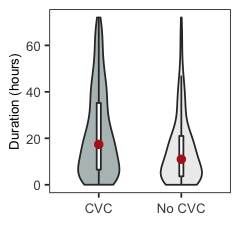

In [166]:
options(repr.plot.width=2, repr.plot.height=2)
p <- output_df %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA)+
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick")
        #+ facet_grid(. ~fancy_pressor)
plot(p)

In [167]:
pdf(file.path(PLOT_DIR, "cvcduration.pdf"), 2,2)
plot(p)
dev.off()

Warning message:
“Removed 2354 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 2354 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 2354 rows containing non-finite values (stat_summary).”

pdf 
  2

In [153]:
for(presor_choice in pressor_choices){
    pairwise.wilcox.test(as.numeric(filter(output_df,pressor==pressor_choice)$duration), 
                     filter(output_df,pressor==pressor_choice)$cvc) %>% 
    print()
}


	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

	Pairwise comparisons using Wilcoxon rank sum test 

data:  as.numeric(filter(output_df, pressor == pressor_choice)$duration) and filter(output_df, pressor == pressor_choice)$cvc 

     FALSE 
TRUE <2e-16

P value adjustment method: holm 

	Pairwise comparisons using Wilcoxon ra

Warning message:
“Removed 678 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 678 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 678 rows containing non-finite values (stat_summary).”

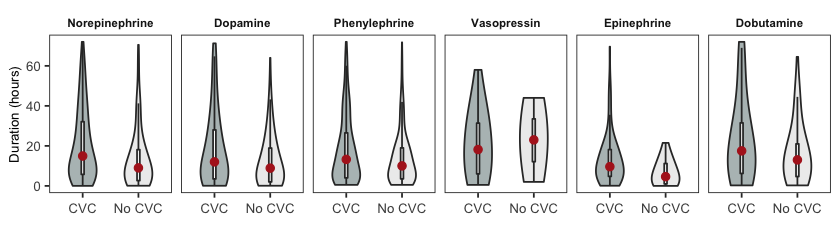

In [706]:
options(repr.plot.width=7, repr.plot.height=2)
p <- output_df %>%
    filter(!grepl(",", pressor)) %>%
    rowwise() %>%
    mutate(cvc_fancy = if(cvc){"CVC"}else{"No CVC"}) %>%
    mutate(cvc_fancy = factor(cvc_fancy, levels = names(CVC_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x=cvc_fancy, y=duration)) +
        base_theme() + 
        theme(legend.position="none") +
        xlab("") +
        ylab("Duration (hours)") +
        geom_violin(aes(fill=cvc_fancy), alpha=0.4, scale="width", trim=TRUE, adjust=2, width=0.5) +
        scale_fill_manual(values=CVC_COLORS) +
        scale_y_continuous(limits=c(0,72)) +
        geom_boxplot(width=0.05, outlier.shape = NA) +
        stat_summary(fun.y=median, geom="point", size=2, color="firebrick") +
        facet_grid(. ~fancy_pressor)
plot(p)

In [1071]:
pdf(file.path(PLOT_DIR, "cvcduration_eachpressor.pdf"), 4,2)
plot(p)
dev.off()

Warning message:
“Removed 1354 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 1354 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 1354 rows containing non-finite values (stat_summary).”

pdf 
  2

### Table 1 Demographics

In [204]:
t1_df <- output_df %>% 
    group_by(STATUS) %>%
    summarize(n = n(), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste('±', sd(age, na.rm=TRUE) %>% round(2))), 
            Male = paste(sum(gender == 'M'), paste0('(',round(sum(gender == 'M')/n(),2),')')),
            MICU = paste(sum(first_careunit == 'MICU'), paste0('(',round(sum(first_careunit == 'MICU')/n(),2),')')),
            SICU = paste(sum(first_careunit == 'SICU'), paste0('(',round(sum(first_careunit == 'SICU')/n(),2),')')),
            CCU = paste(sum(first_careunit == 'CCU'), paste0('(',round(sum(first_careunit == 'CCU')/n(),2),')')),
            TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',round(sum(first_careunit == 'TSICU')/n(),2),')')),
            CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',round(sum(first_careunit == 'CSRU')/n(),2),')')),
            Sepsis = paste(sum(simple_diagnosis == "SEPSIS"), paste0('(',round(sum(simple_diagnosis == "SEPSIS")/n(),2),')')),
            Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',round(sum(simple_diagnosis == "INFECTION")/n(),2),')')),
            Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',round(sum(simple_diagnosis == "CARDIAC")/n(),2),')')),
            CVC = paste(sum(cvc == "TRUE"), paste0('(',round(sum(cvc == "TRUE")/n(),2),')')),
            Intubated = paste(sum(intub == "TRUE"), paste0('(',round(sum(intub == "TRUE")/n(),2),')'))
             ) %>% t()

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [205]:
colnames(t1_df) <- t1_df[1,]

In [206]:
t1_df

,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
STATUS,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
n,5064,3508,6713
Age,65.52 ± 13.88,66.16 ± 13.93,65.72 ± 14.27
Male,3098 (0.61),2081 (0.59),3978 (0.59)
MICU,1267 (0.25),784 (0.22),2102 (0.31)
SICU,583 (0.12),382 (0.11),850 (0.13)
CCU,659 (0.13),457 (0.13),985 (0.15)
TSICU,427 (0.08),292 (0.08),603 (0.09)
CSRU,2128 (0.42),1593 (0.45),2173 (0.32)
Sepsis,340 (0.07),150 (0.04),528 (0.08)


In [214]:
t1_multi_df <- output_df %>% 
    rowwise() %>%
    mutate(MULTI = if(grepl(",", pressor)){'MULTI'}else{'NOT MULTI'}) %>%
    group_by(MULTI) %>%
    summarize(n = n(), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste('±', sd(age, na.rm=TRUE) %>% round(2))), 
            Male = paste(sum(gender == 'M'), paste0('(',round(sum(gender == 'M')/n(),2),')')),
            MICU = paste(sum(first_careunit == 'MICU'), paste0('(',round(sum(first_careunit == 'MICU')/n(),2),')')),
            SICU = paste(sum(first_careunit == 'SICU'), paste0('(',round(sum(first_careunit == 'SICU')/n(),2),')')),
            CCU = paste(sum(first_careunit == 'CCU'), paste0('(',round(sum(first_careunit == 'CCU')/n(),2),')')),
            TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',round(sum(first_careunit == 'TSICU')/n(),2),')')),
            CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',round(sum(first_careunit == 'CSRU')/n(),2),')')),
            Sepsis = paste(sum(simple_diagnosis == "SEPSIS"), paste0('(',round(sum(simple_diagnosis == "SEPSIS")/n(),2),')')),
            Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',round(sum(simple_diagnosis == "INFECTION")/n(),2),')')),
            Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',round(sum(simple_diagnosis == "CARDIAC")/n(),2),')')),
            CVC = paste(sum(cvc == "TRUE"), paste0('(',round(sum(cvc == "TRUE")/n(),2),')')),
            Intubated = paste(sum(intub == "TRUE"), paste0('(',round(sum(intub == "TRUE")/n(),2),')'))
             ) %>% t()

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [215]:
colnames(t1_multi_df) <- t1_multi_df[1,]

In [216]:
t1_multi_df

,MULTI,NOT MULTI
MULTI,MULTI,NOT MULTI
n,5223,10062
Age,66.31 ± 14.32,65.46 ± 13.92
Male,3124 (0.6),6033 (0.6)
MICU,1623 (0.31),2530 (0.25)
SICU,586 (0.11),1229 (0.12)
CCU,826 (0.16),1275 (0.13)
TSICU,423 (0.08),899 (0.09)
CSRU,1765 (0.34),4129 (0.41)
Sepsis,413 (0.08),605 (0.06)


In [217]:
cbind(t1_df, t1_multi_df) %>% write.csv(file.path(PLOT_DIR, "response_demographics.csv"))

### Supplement Table (solo agents)

In [188]:
round(1/3,2)

[1] 0.33

In [186]:
paste0('(',1/3 %>% round(2),')')

[1] "(0.333333333333333)"

In [218]:
s1_3_df <- output_df %>% 
    filter(!grepl(",", pressor)) %>%
    group_by(STATUS, pressor) %>%
    summarize(n = n(), 
            Age = paste(round(as.numeric(mean(age, na.rm=TRUE)),2), paste('±', sd(age, na.rm=TRUE) %>% round(2))), 
            Male = paste(sum(gender == 'M'), paste0('(',round(sum(gender == 'M')/n(),2),')')),
            MICU = paste(sum(first_careunit == 'MICU'), paste0('(',round(sum(first_careunit == 'MICU')/n(),2),')')),
            SICU = paste(sum(first_careunit == 'SICU'), paste0('(',round(sum(first_careunit == 'SICU')/n(),2),')')),
            CCU = paste(sum(first_careunit == 'CCU'), paste0('(',round(sum(first_careunit == 'CCU')/n(),2),')')),
            TSICU = paste(sum(first_careunit == 'TSICU'), paste0('(',round(sum(first_careunit == 'TSICU')/n(),2),')')),
            CSRU = paste(sum(first_careunit == 'CSRU'), paste0('(',round(sum(first_careunit == 'CSRU')/n(),2),')')),
            Sepsis = paste(sum(simple_diagnosis == "SEPSIS"), paste0('(',round(sum(simple_diagnosis == "SEPSIS")/n(),2),')')),
            Infectious = paste(sum(simple_diagnosis == "INFECTION"), paste0('(',round(sum(simple_diagnosis == "INFECTION")/n(),2),')')),
            Cardiac = paste(sum(simple_diagnosis == "CARDIAC"), paste0('(',round(sum(simple_diagnosis == "CARDIAC")/n(),2),')')),
            CVC = paste(sum(cvc == "TRUE"), paste0('(',round(sum(cvc == "TRUE")/n(),2),')')),
            Intubated = paste(sum(intub == "TRUE"), paste0('(',round(sum(intub == "TRUE")/n(),2),')'))
             )

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [226]:
for(pressor_choice in pressor_choices){
    output_df <- s1_3_df %>%
        filter(pressor == pressor_choice) %>%
        t()
    colnames(output_df) <- output_df[1,]
    output_df %>% 
        data.frame() %>%
        select(LESSTHAN6HOURS, LESSTHAN24HOURS, MORETHAN24HOURS) %>%
        write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_demographics.csv")))
}

# Categorical Predictors

In [718]:
# This function, given a dataframe with the appropriate columns, will compute RR statistics and return as a table 
calculatePredictors <- function(df){
    all_rr_list <- list()

    # gender
    output <- df %>%
        group_by(RESPONSE, gender) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("gender") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['MALE_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'M') %>%
            mutate(ID = "M", p = output$p.value["M","fisher.exact"])


#     # race
#     rr_list <- list()
#     for(race in races){
#        output <- df %>%
#             rowwise() %>%
#             group_by(RESPONSE, simple_race) %>%
#             summarize(COUNT = n()) %>%
#             mutate(RACE_BOOL = simple_race == race) %>%
#             group_by(RACE_BOOL, RESPONSE) %>%
#             summarize(COUNT = sum(COUNT)) %>%
#             spread(RESPONSE, COUNT) %>%
#             tibble::column_to_rownames("RACE_BOOL") %>%
#             as.matrix() %>% riskratio() 
#         rr_list[[race]] <- output$measure %>%
#             data.frame() %>%
#             tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
#             mutate(ID = race, p = output$p.value["TRUE","fisher.exact"])
#     }


#     all_rr_list[['RACE_RR']] <- bind_rows(rr_list)


    # age
    age_df <- df %>%
        group_by(RESPONSE, age_cohort) %>%
        summarize(COUNT = n()) %>%
        drop_na(age_cohort)

    rr_list <- list()
    for(ac in unique(age_df$age_cohort)){
       if(ac != 0){
           output <- age_df %>%
                mutate(AGE_BOOL = age_cohort == ac) %>%
                group_by(AGE_BOOL, RESPONSE) %>%
                summarize(COUNT = sum(COUNT)) %>%
                spread(RESPONSE, COUNT) %>%
                tibble::column_to_rownames("AGE_BOOL") %>%
                as.matrix() %>% riskratio() 

            rr_list[[ac]] <- output$measure %>%
                data.frame() %>%
                tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
                mutate(ID = as.character(ac), p = output$p.value["TRUE","fisher.exact"])
       }  
    }

    all_rr_list[['AGE_RR']] <- bind_rows(rr_list)


    # diagnosis
    diagnosis_df <- df %>%
        rowwise() %>%
        group_by(simple_diagnosis, RESPONSE) %>%
        summarize(COUNT = n()) 

    rr_list <- list()
    for(s_d in unique(diagnosis_df$simple_diagnosis)){
       output <- diagnosis_df %>%
            mutate(DX_BOOL = simple_diagnosis == s_d) %>%
            group_by(DX_BOOL, RESPONSE) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(RESPONSE, COUNT) %>%
            tibble::column_to_rownames("DX_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[s_d]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = s_d, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['DIAGNOSIS_RR']] <- bind_rows(rr_list)


    # careunit
    careunit_df <- df %>%
        group_by(RESPONSE, first_careunit) %>%
        summarize(COUNT = n())

    rr_list <- list()
    for(cu in unique(careunit_df$first_careunit)){
       output <- careunit_df%>%
            mutate(CU_BOOL = first_careunit == cu) %>%
            group_by(CU_BOOL, RESPONSE) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(RESPONSE, COUNT) %>%
            tibble::column_to_rownames("CU_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[cu]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = cu, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['CAREUNIT_RR']] <- bind_rows(rr_list)


    # intub
    output <- df %>%
        group_by(RESPONSE, intub) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("intub") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['INTUB_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "INTUB", p = output$p.value["TRUE","fisher.exact"])

    # cvc
    output <- df %>%
        group_by(RESPONSE, cvc) %>%
        summarize(COUNT = n()) %>%
        spread(RESPONSE, COUNT) %>%
        tibble::column_to_rownames("cvc") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['CVC_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "CVC", p = output$p.value["TRUE","fisher.exact"])


    # combined
    all_rr_df <- bind_rows(all_rr_list, .id="TYPE") %>%
        mutate(significant = p < 0.05)
    
    return(all_rr_df)
}


# Table 1 (RR significance)

In [719]:
rr_df <- calculatePredictors(output_df) %>%
    rowwise() %>%
    mutate(ID = if(ID == "M"){"MALE"}else{ID}) %>% select(-FILTER)
rr_df

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

TYPE,estimate,lower,upper,ID,p,significant
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
MALE_RR,0.9619837,0.9334474,0.9913924,MALE,1.251451e-02,TRUE
AGE_RR,1.0232508,0.8871223,1.1802682,20,8.112433e-01,FALSE
AGE_RR,1.0262155,0.9259281,1.1373649,30,6.456563e-01,FALSE
AGE_RR,1.0708553,1.0014896,1.1450255,40,5.567368e-02,FALSE
AGE_RR,0.9602825,0.9168750,1.0057452,50,8.308530e-02,FALSE
AGE_RR,0.9719828,0.9365458,1.0087608,60,1.307216e-01,FALSE
AGE_RR,0.9800910,0.9465626,1.0148069,70,2.602350e-01,FALSE
AGE_RR,1.0557031,1.0202500,1.0923881,80,2.189679e-03,TRUE
AGE_RR,0.9819059,0.9148168,1.0539150,90,6.225386e-01,FALSE


In [720]:
rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk.csv"))

### Supplement (single agents)
- Insufficient numbers for RR analysis for epinephrine and vasopressin

In [721]:
pressor_rr_list <- list()
for(pressor_choice in c('norepinephrinedurations', 'dopaminedurations', 'phenylephrinedurations')){
    pressor_rr_list[[pressor_choice]] <- output_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        calculatePredictors()
}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message

In [722]:
pressor_rr_df <- bind_rows(pressor_rr_list, .id="pressor")  %>% select(-FILTER)

In [723]:
pressor_rr_df

pressor,TYPE,estimate,lower,upper,ID,p,significant
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
norepinephrinedurations,MALE_RR,1.0190057,0.9891411,1.0497720,M,2.226992e-01,FALSE
norepinephrinedurations,AGE_RR,0.9375607,0.8078868,1.0880486,20,3.563539e-01,FALSE
norepinephrinedurations,AGE_RR,1.0182311,0.9302911,1.1144841,30,7.806508e-01,FALSE
norepinephrinedurations,AGE_RR,1.0337854,0.9703307,1.1013897,40,3.495062e-01,FALSE
norepinephrinedurations,AGE_RR,1.0049333,0.9627929,1.0489182,50,8.638935e-01,FALSE
norepinephrinedurations,AGE_RR,0.9856754,0.9498223,1.0228817,60,4.468820e-01,FALSE
norepinephrinedurations,AGE_RR,1.0145757,0.9805363,1.0497967,70,4.289038e-01,FALSE
norepinephrinedurations,AGE_RR,1.0006974,0.9670886,1.0354742,80,1.000000e+00,FALSE
norepinephrinedurations,AGE_RR,0.9570152,0.8935094,1.0250346,90,2.040189e-01,FALSE


In [724]:
pressor_rr_df %>% 
    write.csv(file.path(PLOT_DIR, "relativerisk_eachpressor.csv"))

# Figure 1 Plotting RR

In [126]:
SIGNIFICANT_COLORS <- c(
"Significant" = '#2F4F4F',
"Not Significant" = '#D3D3D3'
)

In [127]:
ID_DICT <- c(
'M' = "Male Gender",
'INTUB' = "Intubated",
'CVC' = "CVC Placed",
'20' = "Age 15-25",
'30' = "Age 25-35",
'40' = "Age 35-45",
'50' = "Age 45-55",
'60' = "Age 55-65",
'70' = "Age 65-75",
'80' = "Age 75-85",
'90' = "Age 85-95",
'CARDIAC' = "Cardiac Diagnosis",
'INFECTION' = "Infectious Diagnosis",
'SEPSIS' = "Sepsis Diagnosis",
'OTHER DIAGNOSIS' = "Other Diagnosis",
'CCU' = 'CCU',
'CSRU' = 'CSRU',
'MICU' = 'MICU',
'SICU' = 'SICU',
'TSICU' = 'TSICU'
)

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

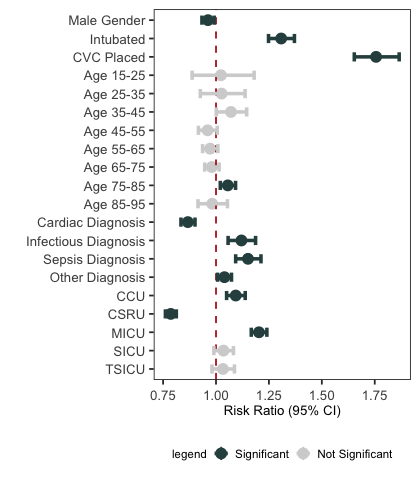

In [727]:
options(repr.plot.width=3.5, repr.plot.height=4)
p <- calculatePredictors(output_df)  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [728]:
pdf(file.path(PLOT_DIR, "relativerisk.pdf"), 3.5,4)
plot(p)
dev.off()

pdf 
  2

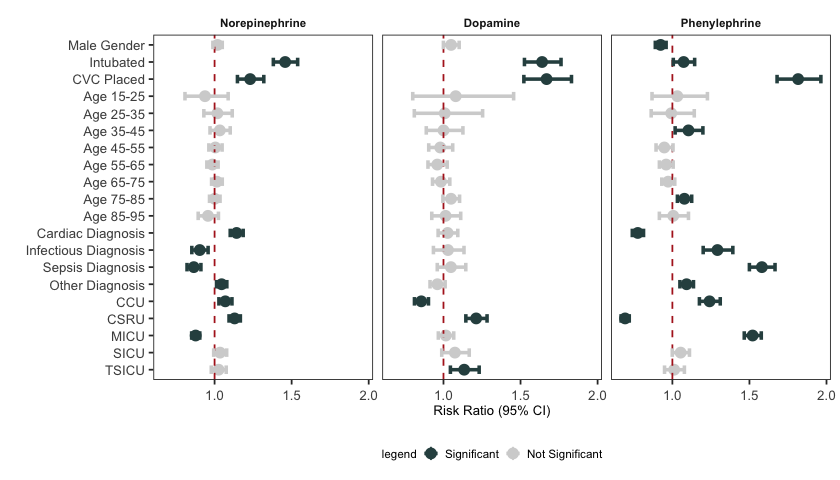

In [729]:
options(repr.plot.width=7, repr.plot.height=4)
p <- pressor_rr_df  %>%
    rowwise() %>%
    mutate(ID = ID_DICT[ID]) %>% 
    mutate(ID = factor(ID, levels=rev(ID_DICT))) %>%
    mutate(significant = if(significant){'Significant'}else{'Not Significant'}) %>%
    mutate(legend = factor(significant, levels=names(SIGNIFICANT_COLORS))) %>%
    mutate(fancy_pressor = FANCY_PRESSOR_DICT[as.character(pressor)]) %>%
    mutate(fancy_pressor = factor(fancy_pressor, levels=FANCY_PRESSOR_ORDER)) %>%
    ggplot(aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
        base_theme() +
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Risk Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
        coord_flip() + 
        facet_grid(. ~fancy_pressor)
plot(p)

In [730]:
pdf(file.path(PLOT_DIR, "relativerisk_eachpressor.pdf"), 7,4)
plot(p)
dev.off()

pdf 
  2

# Vitals

### Pre-processing (30 minutes): read in vitals_df, join with output_df of courses and compute mean vitals information each hour -> results_df

In [101]:
vitals_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/vitals.csv')

In [102]:
# takes 6 mins to run (because of difftime)

vitals_merged_df <- vitals_df %>%
    mutate(charttime = fastPOSIXct(charttime)) %>%
    filter(icustay_id %in% output_df$icustay_id) %>%
    left_join(select(output_df, icustay_id, course_id, pressor, starttime, endtime, MORETHAN24HOURS, RESPONSE, STATUS), by = "icustay_id") %>%
    rowwise() %>%
    mutate(diff = difftime(charttime, 
                       starttime, units="hours"))

In [103]:
# for 10 hours prior to pressor initiation
intervals <- 1:10

In [104]:
results_list <- list()

In [105]:
# takes 40 mins to run overall
for(interval in intervals){
    # 4 mins to run each
    results_list[[interval]] <- vitals_merged_df %>%
        filter(diff < 0) %>%
        filter(diff < -(interval - 1) & diff > -interval) %>%
        group_by(MORETHAN24HOURS, RESPONSE, STATUS, course_id, pressor) %>%
        summarize(mean_heartrate = mean(heartrate, na.rm=T), 
                  mean_sysbp = mean(sysbp, na.rm=T),
                  mean_diasbp = mean(diasbp, na.rm=T),
                  mean_meanbp = mean(meanbp, na.rm=T), 
                  mean_resprate = mean(resprate, na.rm=T), 
                  mean_tempc = mean(tempc, na.rm=T), 
                  mean_spo2 = mean(spo2, na.rm=T), 
                  mean_glucose = mean(glucose, na.rm=T), 

                  median_heartrate = median(heartrate, na.rm=T), 
                  median_sysbp = median(sysbp, na.rm=T),
                  median_diasbp = median(diasbp, na.rm=T),
                  median_meanbp = median(meanbp, na.rm=T), 
                  median_resprate = median(resprate, na.rm=T), 
                  median_tempc = median(tempc, na.rm=T), 
                  median_spo2 = median(spo2, na.rm=T), 
                  median_glucose = median(glucose, na.rm=T),

                 ) %>%
        mutate(INTERVAL = interval)

}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [106]:
results_df <- bind_rows(results_list) 

In [107]:
melt_results_df <- results_df %>% 
    gather("ID", "VALUE", -course_id, -pressor, -MORETHAN24HOURS, -INTERVAL, -STATUS, -RESPONSE)

In [108]:
head(melt_results_df)

MORETHAN24HOURS,RESPONSE,STATUS,course_id,pressor,INTERVAL,ID,VALUE
<lgl>,<lgl>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>
FALSE,FALSE,LESSTHAN24HOURS,"200033,0",phenylephrinedurations,1,mean_heartrate,118.00000
FALSE,FALSE,LESSTHAN24HOURS,"200075,0",norepinephrinedurations,1,mean_heartrate,83.50000
FALSE,FALSE,LESSTHAN24HOURS,"200078,0",phenylephrinedurations,1,mean_heartrate,100.00000
FALSE,FALSE,LESSTHAN24HOURS,"200143,0",phenylephrinedurations,1,mean_heartrate,104.00000
FALSE,FALSE,LESSTHAN24HOURS,"200168,0",phenylephrinedurations,1,mean_heartrate,92.33333
FALSE,FALSE,LESSTHAN24HOURS,"200172,0",phenylephrinedurations,1,mean_heartrate,100.00000


In [109]:
melt_results_df %>% write.csv('~/Projects/Haimovich_Pressors/collection/out/melt_summarized_vitals.csv')


### ANCOVA analysis using intervals
- MORETHAN24HOURS P-value tells you if this vital sign is a predictor (BP, HR, RR, TEMP)
- INTERVAL P-value tells you if these values change depending on the interval being measured (most values)
- MORETHAN24HOURS:INTERVAL P-value tells you if vital sign interacts with the interval being measured, that is, the extent of predictive value differs with time (BP especially, others are borderline significant)

In [742]:
computeANCOVA <- function(df) {
    vitals_result_list <- list()
    for(vital in unique(melt_results_df$ID)){
        #cat("####", vital, "####")
        totest <- df %>%
             filter(ID == vital)
        test <- summary(aov(VALUE ~ RESPONSE*INTERVAL, data = totest))[[1]]

        vitals_result_list[[vital]] <- data.frame(RESPONSE = test["RESPONSE ", "Pr(>F)"], 
                                                 INTERACTION = test["RESPONSE:INTERVAL", "Pr(>F)"])
    }
    vitals_result_df <- bind_rows(vitals_result_list, .id="ID")
    
    return(vitals_result_df)
}

# Table 2 (Wilcox and ANCOVA Vitals)

In [743]:
computeTest <- function(d, value="VALUE", comparison="GROUP"){
    paired_df <- d %>% 
        select(!!rlang::sym(comparison), !!rlang::sym(value)) 
    
    items <- unique(unlist(d[,comparison]))

    result_unpair <- t.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    result_wilcox <- wilcox.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    
    diff = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE) -  
        mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE)
    
    return(data.frame(list(
                           'P_UNPAIR' = result_unpair$p.value, 
                           'P_WILCOX' = result_wilcox$p.value,
                            'GROUP1' = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE),
                            'GROUP2' = mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE),
                            'DIFF' = diff,
                            'COMPARE' = paste(items[1], items[2], sep ='-'))))
}

### Table 2. mean and standard deviation of vitals  for different time status

In [744]:
# means
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS) %>%
    summarize(MEAN = mean(VALUE)) %>%
    spread(STATUS, MEAN)

ID,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,55.37023,56.99650,54.93355
mean_glucose,146.06641,144.46735,153.15957
mean_heartrate,87.87453,85.61411,91.85647
mean_meanbp,71.70073,73.68811,70.60429
mean_resprate,17.36197,17.14523,18.46265
mean_spo2,97.54037,97.78287,97.10865
mean_sysbp,106.10209,109.61410,103.94547
mean_tempc,36.44315,36.37354,36.44021
median_diasbp,55.22337,56.76997,54.73521


In [745]:
# standard deviations
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS) %>%
    summarize(SD = sd(VALUE)) %>%
    spread(STATUS, SD)

ID,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,12.561892,13.779953,13.401969
mean_glucose,58.667660,57.857145,69.701030
mean_heartrate,18.834364,18.682948,20.745076
mean_meanbp,14.287962,15.269939,15.393831
mean_resprate,5.697430,5.469036,6.063065
mean_spo2,4.974435,4.422410,4.743563
mean_sysbp,18.813130,20.643224,20.088076
mean_tempc,1.099717,1.140719,1.167412
median_diasbp,12.731813,13.937027,13.564979


In [746]:
# means
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    filter(!grepl(",", pressor)) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS, pressor) %>%
    summarize(MEAN = mean(VALUE)) %>%
    ungroup() %>%
    filter(pressor %in% pressor_choices) %>%
    spread(STATUS, MEAN) %>% arrange(pressor)

ID,pressor,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,dobutaminedurations,59.41122,58.66173,62.37027
mean_glucose,dobutaminedurations,153.00000,177.70000,170.64706
mean_heartrate,dobutaminedurations,93.11535,92.03482,87.64487
mean_meanbp,dobutaminedurations,78.58543,75.35625,78.86065
mean_resprate,dobutaminedurations,17.96560,19.27232,19.13462
mean_spo2,dobutaminedurations,97.71396,96.94921,96.81532
mean_sysbp,dobutaminedurations,118.48107,108.78549,112.85901
mean_tempc,dobutaminedurations,36.37134,36.40770,36.65876
median_diasbp,dobutaminedurations,59.39103,58.52778,62.39865


In [747]:
# standard deviations
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    filter(!grepl(",", pressor)) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS, pressor) %>%
    summarize(SD = sd(VALUE)) %>%
    ungroup() %>%
    filter(pressor %in% pressor_choices) %>%
    spread(STATUS, SD) %>% arrange(pressor)

ID,pressor,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
<chr>,<chr>,<dbl>,<dbl>,<dbl>
mean_diasbp,dobutaminedurations,13.2121293,12.3186727,11.350842
mean_glucose,dobutaminedurations,70.2890856,56.9640237,87.109982
mean_heartrate,dobutaminedurations,19.2109650,20.7838561,16.564982
mean_meanbp,dobutaminedurations,12.9471320,16.7683928,14.357230
mean_resprate,dobutaminedurations,6.1972842,5.3561011,6.376745
mean_spo2,dobutaminedurations,2.5189514,3.0642106,2.423453
mean_sysbp,dobutaminedurations,14.0865003,23.7966779,23.766242
mean_tempc,dobutaminedurations,0.9577694,0.6543347,1.336907
median_diasbp,dobutaminedurations,13.1056932,12.4387602,11.189879


### Wilcox for significant difference at <1 hr before start of pressors

All pressors

In [748]:
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    do(computeTest(.,value="VALUE", comparison="RESPONSE")) %>%
    mutate(significant = P_WILCOX < 0.05)

ID,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,1.101452e-08,3.261272e-12,56.31367,54.87639,1.43727392,FALSE-TRUE,TRUE
mean_glucose,6.839439e-13,1.393181e-08,142.76269,154.13758,-11.37488696,FALSE-TRUE,TRUE
mean_heartrate,2.545628e-56,1.031978e-55,86.00262,91.85977,-5.85714792,FALSE-TRUE,TRUE
mean_meanbp,9.042397e-18,1.581916e-24,72.97114,70.52538,2.44576033,FALSE-TRUE,TRUE
mean_resprate,2.045813e-44,5.037580e-42,17.00707,18.48530,-1.47823868,FALSE-TRUE,TRUE
mean_spo2,8.426036e-28,3.891507e-33,97.92432,96.94168,0.98263968,FALSE-TRUE,TRUE
mean_sysbp,3.096190e-32,5.683846e-42,108.32635,103.86175,4.46460288,FALSE-TRUE,TRUE
mean_tempc,5.603909e-01,3.707439e-01,36.43498,36.41712,0.01785834,FALSE-TRUE,FALSE
median_diasbp,3.557355e-09,1.194926e-12,56.16053,54.65767,1.50285421,FALSE-TRUE,TRUE


Pressors by type

In [749]:
melt_results_df %>%
    filter(!grepl(",", pressor)) %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    mutate(pressor = factor(pressor, levels=pressor_choices)) %>%
    group_by(ID, pressor) %>%
    do(computeTest(.,value="VALUE", comparison="RESPONSE")) %>%
    mutate(significant = P_WILCOX < 0.05) %>%
    arrange(pressor)

Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, :
“cannot compute exact p-value with ties”Warning message in wilcox.test.default(filter(d,

ID,pressor,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,norepinephrinedurations,2.380075e-03,3.252469e-04,55.81099,53.69076,2.12023012,FALSE-TRUE,TRUE
mean_glucose,norepinephrinedurations,4.793384e-02,5.977964e-02,162.70839,151.60551,11.10288021,FALSE-TRUE,FALSE
mean_heartrate,norepinephrinedurations,3.060525e-03,1.202861e-03,88.75726,91.46629,-2.70903315,FALSE-TRUE,TRUE
mean_meanbp,norepinephrinedurations,5.996111e-05,4.914404e-07,70.55805,67.47999,3.07806070,FALSE-TRUE,TRUE
mean_resprate,norepinephrinedurations,4.954806e-06,2.567574e-06,19.20021,20.43339,-1.23317687,FALSE-TRUE,TRUE
mean_spo2,norepinephrinedurations,6.730529e-02,8.750777e-03,97.12409,96.71670,0.40738285,FALSE-TRUE,TRUE
mean_sysbp,norepinephrinedurations,8.843570e-07,5.817102e-09,105.60703,100.78033,4.82670330,FALSE-TRUE,TRUE
mean_tempc,norepinephrinedurations,3.409375e-01,3.954186e-01,36.55410,36.63706,-0.08295573,FALSE-TRUE,FALSE
median_diasbp,norepinephrinedurations,2.309440e-03,3.882486e-04,55.64669,53.49656,2.15013441,FALSE-TRUE,TRUE


### ANCOVA for significant differences summarized

Total pressors

In [751]:
ancova_significance_df <- computeANCOVA(melt_results_df) %>% mutate(
    response_significant = RESPONSE < 0.05, 
    interaction_interaction = INTERACTION < 0.05) %>%
    rename(response_pvalue = RESPONSE, interaction_pvalue = INTERACTION, vital_sign = ID)
ancova_significance_df

vital_sign,response_pvalue,interaction_pvalue,response_significant,interaction_interaction
<chr>,<dbl>,<dbl>,<lgl>,<lgl>
mean_heartrate,5.961964e-134,5.046172e-04,TRUE,TRUE
mean_sysbp,5.942932e-110,8.620336e-02,TRUE,FALSE
mean_diasbp,1.825862e-11,1.657407e-01,TRUE,FALSE
mean_meanbp,3.567647e-40,2.388032e-01,TRUE,FALSE
mean_resprate,2.104938e-177,6.048216e-01,TRUE,FALSE
mean_tempc,4.812561e-01,9.785645e-01,FALSE,FALSE
mean_spo2,4.189830e-95,2.649890e-06,TRUE,TRUE
mean_glucose,6.287661e-33,6.558040e-03,TRUE,TRUE
median_heartrate,5.240860e-134,4.944930e-04,TRUE,TRUE


In [752]:
ancova_significance_df %>% write.csv(file.path(PLOT_DIR, "ancovasignificance.csv"))

Pressors by type

In [753]:
pressors_vitals_rr_list <- list()
for(pressor_choice in pressor_choices){
    pressors_vitals_rr_list[[pressor_choice]] <- melt_results_df %>%
        filter(grepl(pressor_choice, pressor)) %>%
        computeANCOVA() %>%
        mutate(
            response_significant = RESPONSE < 0.05, 
            interaction_interaction = INTERACTION < 0.05)
}

pressors_vitals_rr_df <- bind_rows(pressors_vitals_rr_list, .id="pressor")

In [754]:
ancova_significance_eachpressor_df <- pressors_vitals_rr_df %>%
    rename(response_pvalue = RESPONSE, interaction_pvalue = INTERACTION, vital_sign = ID)
ancova_significance_eachpressor_df

pressor,vital_sign,response_pvalue,interaction_pvalue,response_significant,interaction_interaction
<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>
norepinephrinedurations,mean_heartrate,4.967742e-34,2.316237e-04,TRUE,TRUE
norepinephrinedurations,mean_sysbp,2.415438e-15,7.786015e-01,TRUE,FALSE
norepinephrinedurations,mean_diasbp,5.585522e-01,1.081975e-02,FALSE,TRUE
norepinephrinedurations,mean_meanbp,2.578338e-02,1.706577e-01,TRUE,FALSE
norepinephrinedurations,mean_resprate,1.342474e-30,4.752885e-02,TRUE,TRUE
norepinephrinedurations,mean_tempc,1.956959e-02,4.795913e-01,TRUE,FALSE
norepinephrinedurations,mean_spo2,2.295970e-11,2.465466e-05,TRUE,TRUE
norepinephrinedurations,mean_glucose,1.744276e-01,5.946501e-01,FALSE,FALSE
norepinephrinedurations,median_heartrate,6.240282e-34,2.428656e-04,TRUE,TRUE


In [755]:
ancova_significance_eachpressor_df %>% write.csv(file.path(PLOT_DIR, "ancovasignificance_eachpressor.csv"))

# Figure 2 ANCOVA Plotting

In [229]:
toplot <- melt_results_df %>%
    mutate(INTERVAL = -INTERVAL) %>%
    drop_na(VALUE) %>%
    filter(grepl("mean_", ID), ID != "mean_diasbp", ID != "mean_sysbp")

Total pressors

In [230]:
FANCY_VITAL_ORDER <- c('MAP', 'HR', 'RR', 'SpO2', 'Temperature', 'Glucose')

In [231]:
FANCY_VITAL_DICT <- c(
    'mean_meanbp' = 'MAP', 
    'mean_heartrate' = 'HR', 
    'mean_resprate' = 'RR', 
    'mean_spo2' = 'SpO2', 
    'mean_tempc' = 'Temperature', 
    'mean_glucose' = 'Glucose')

In [232]:
PRESSORHOURS_COLORS <- c(
"Prolonged or multiple pressor" = '#2F4F4F',
"No prolonged or multiple pressor" = '#D3D3D3'
)

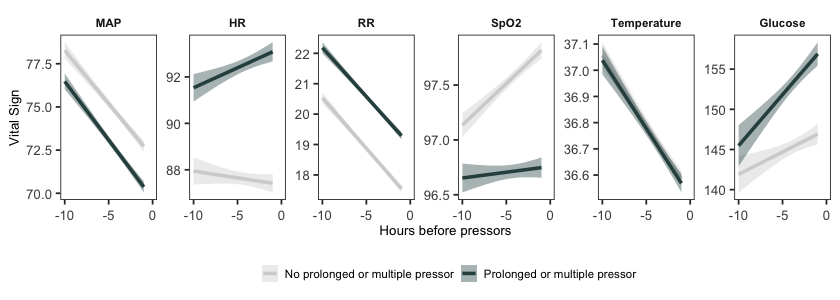

In [234]:
options(repr.plot.width=7, repr.plot.height=2.5)

p <- toplot %>%
    rowwise() %>%
    mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
    mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
    mutate(FANCY_RESPONSE = if(RESPONSE){"Prolonged or multiple pressor"}else{"No prolonged or multiple pressor"}) %>%
    ggplot(aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before pressors") + ylab("Vital Sign") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
plot(p)

In [235]:
pdf(file.path(PLOT_DIR, "ancova_vitals.pdf"), 7,2.5)
plot(p)
dev.off()

pdf 
  2

Pressors by type

In [236]:
pressor_choices

[1] "norepinephrinedurations" "dopaminedurations"      
[3] "phenylephrinedurations"  "vasopressindurations"   
[5] "epinephrinedurations"    "dobutaminedurations"

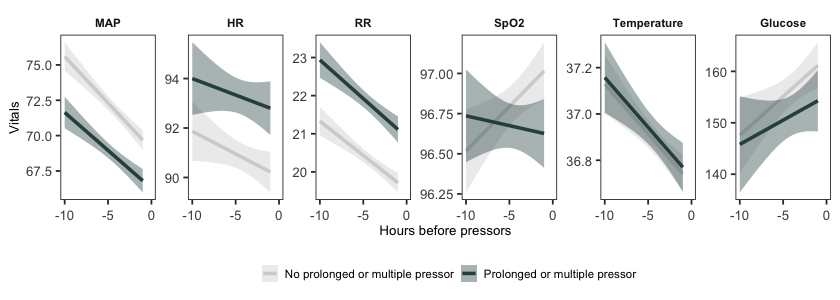

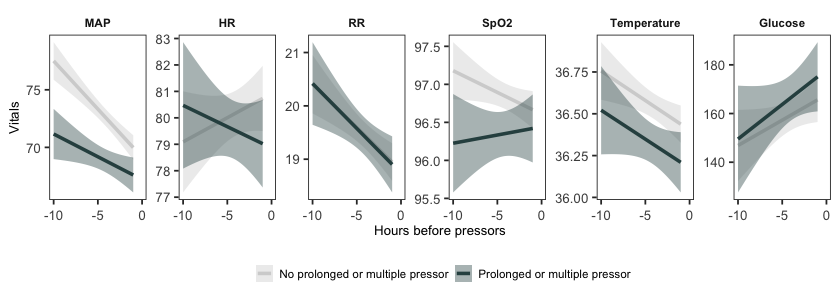

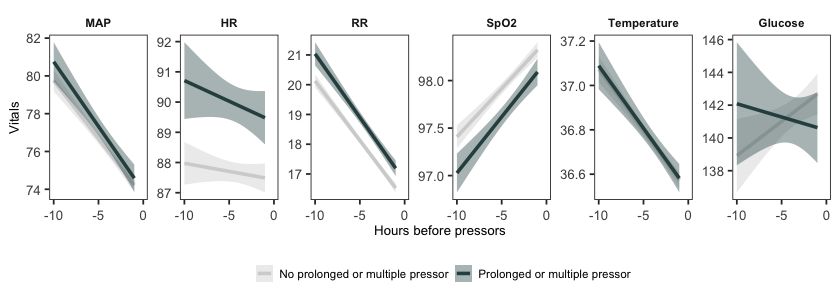

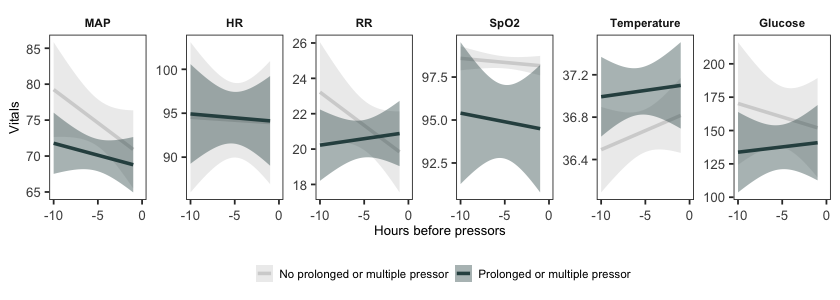

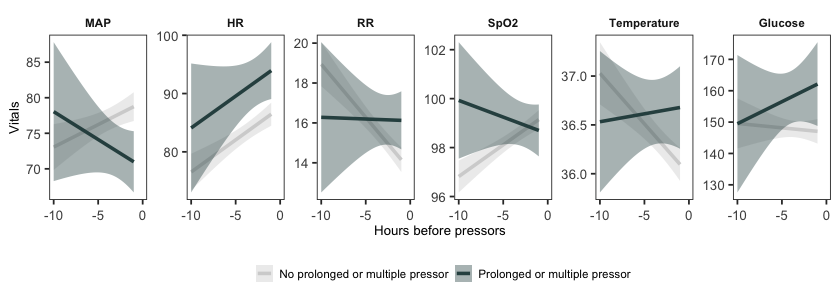

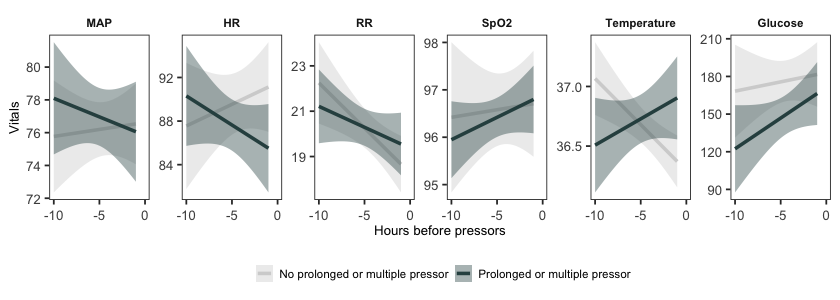

In [237]:
options(repr.plot.width=7, repr.plot.height=2.5)
for(pressor_choice in pressor_choices){
    toplot <- melt_results_df %>%
        filter(!grepl(",", pressor)) %>%
        mutate(INTERVAL = -INTERVAL) %>%
        drop_na(VALUE) %>%
        filter(pressor == pressor_choice, grepl("mean_", ID), ID != "mean_diasbp", ID != "mean_sysbp") %>%
        rowwise() %>%
        mutate(FANCY_VITAL = FANCY_VITAL_DICT[ID]) %>%
        mutate(FANCY_VITAL = factor(FANCY_VITAL, levels=FANCY_VITAL_ORDER)) %>%
        mutate(FANCY_RESPONSE = if(RESPONSE){"Prolonged or multiple pressor"}else{"No prolonged or multiple pressor"})

    p <- ggplot(toplot, aes(x=INTERVAL, y=VALUE, color=FANCY_RESPONSE)) +
        geom_smooth(method=lm, aes(fill=FANCY_RESPONSE)) + 
        xlab("Hours before pressors") + ylab("Vitals") +
        scale_x_continuous(limits=c(-10,0), breaks=seq(-10,0,5)) +
        base_theme() + 
        scale_color_manual(values=PRESSORHOURS_COLORS)+
        scale_fill_manual(values=PRESSORHOURS_COLORS)+
        theme(legend.title = element_blank()) +
        theme(legend.position="bottom") +
        facet_wrap(. ~ FANCY_VITAL, scale="free", nrow=1)
    
#     if(pressor_choice == 'phenylephrinedurations'){
#         p <- p + theme(legend.position="bottom")
#     }
    
    plot(p)
    
    pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_ancova_vitals.pdf")), 7,2.5)
    plot(p)
    dev.off()
}

# LR Summary

In [110]:
set.seed(100)

In [111]:
lr_summary_list <- list()

In [112]:
LR_CATEGORICAL_COEFFICIENT_DICT <- c(
'genderM' = "Male Gender",
'intubTRUE' = "Intubated",
'simple_diagnosisINFECTION' = "Infectious Diagnosis",   
'simple_diagnosisSEPSIS' = "Sepsis Diagnosis",
'simple_diagnosisOTHER DIAGNOSIS' = "Other Diagnosis",
'pressorphenylephrinedurations' = 'phenylephrine',
'pressornorepinephrinedurations' = 'norepinephrine',
'first_careunitCSRU' = 'CSRU',
'first_careunitSICU' = 'SICU',
'first_careunitMICU' = 'MICU',
'first_careunitTSICU' = 'TSICU'
)

In [113]:
LR_CONTINUOUS_COEFFICIENT_DICT <- c(
'age_cohort' = 'Age',
'mean_meanbp' = 'MAP',
'mean_resprate' = 'RR',
'mean_heartrate' = 'HR',
'mean_tempc' = 'Temperature',
'mean_spo2' = 'SpO2',
'mean_glucose' = 'Glucose'
)

### ROC curve with CI

In [114]:
roc_with_ci <- function(obj) {
  ciobj <- ci.se(obj, specificities = seq(0, 1, l = 25))
  dat.ci <- data.frame(x = as.numeric(rownames(ciobj)),
                       lower = ciobj[, 1],
                       upper = ciobj[, 3])
  
  ggroc(obj) +
    base_theme() +
    theme(axis.title=element_text(size=10)) +
    geom_abline(
      slope = 1,
      intercept = 1,
      linetype = "dashed",
      alpha = 0.7,
      color = '#2F4F4F'
    ) + coord_equal() +
    geom_ribbon(
      data = dat.ci,
      aes(x = x, ymin = lower, ymax = upper),
      fill = '#2F4F4F',
      alpha = 0.2
    ) 
} 

# LR Model for Total
- Ran into problems with missing data for glucose, spo2 and tempc, hence the selection of criteria as variables

In [115]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL == 2) %>%
    select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    rowwise() %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE,
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate") ,
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              )

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [116]:
dim(model_input_df) %>% print()

[1] 15285    12


In [117]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [118]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [1491]:
car::vif(model)

,GVIF,Df,GVIF^(1/(2*Df))
first_careunit,2.156076,4,1.100799
intub,1.130508,1,1.063253
simple_diagnosis,1.585638,3,1.079860
age_cohort,1.151027,1,1.072859
gender,1.089497,1,1.043790
mean_meanbp,1.083903,1,1.041107
mean_resprate,1.452612,1,1.205243
mean_heartrate,1.363866,1,1.167847
mean_tempc,1.337124,1,1.156341
mean_spo2,1.147993,1,1.071444


In [1492]:
lr_summary_list[['TOTAL']] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[['TOTAL']] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.6603611,0.03198653,0.6432651,0.02660415


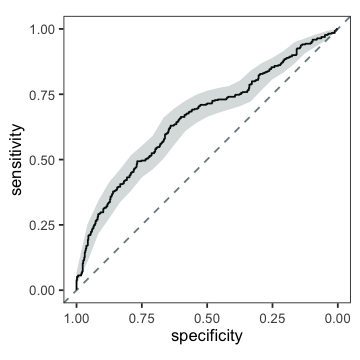

In [1493]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out)

plot(p)

In [1494]:
pdf(file.path(PLOT_DIR, paste0("modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [120]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2477    99.49 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2517   101.11 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2534   101.77 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2553   102.55 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |    0.255   102.40 |


In [1354]:
dim(model_input_df)

[1] 15285    12

In [1329]:
dim(model_input_df)

[1] 14637    12

In [121]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

#### Model parameter significance

In [122]:
summary(model)


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7866  -1.1296   0.8327   1.1057   1.7512  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -0.4437934  0.2068444  -2.146 0.031909 *  
mean_meanbp                     -0.0039561  0.0014028  -2.820 0.004801 ** 
mean_resprate                    0.0132195  0.0039247   3.368 0.000756 ***
mean_heartrate                   0.0043260  0.0011982   3.611 0.000306 ***
mean_tempc                       0.0043113  0.0091776   0.470 0.638520    
mean_spo2                       -0.0077686  0.0033670  -2.307 0.021039 *  
mean_glucose                     0.0016239  0.0004101   3.960 7.49e-05 ***
first_careunitCSRU              -0.6775064  0.0577750 -11.727  < 2e-16 ***
first_careunitMICU               0.0223535  0.0606855   0.368 0.712612    
first_careunitS

In [123]:
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, "modelestimates.csv"))

In [130]:
oddsratio <- exp(cbind(coef(model), confint(model)))  %>% data.frame() 

Waiting for profiling to be done...


In [132]:
oddsratio_categorical <- oddsratio  %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, "categoricalmodeleodds.csv"))

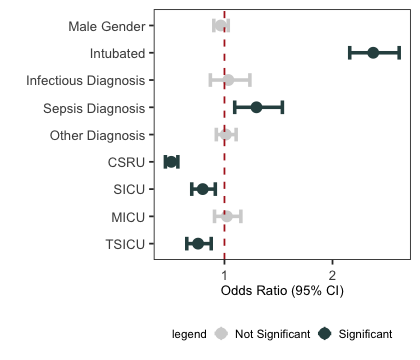

In [128]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>% 
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [1382]:
pdf(file.path(PLOT_DIR, paste0("categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [134]:
oddsratio_continuous <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, "continuousmodeleodds.csv"))

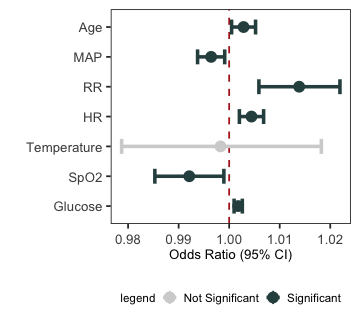

In [1392]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [1398]:
pdf(file.path(PLOT_DIR, paste0("continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

# LR Model for norepinephrine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [136]:
pressor_choice <- 'norepinephrinedurations'

In [137]:
model_input_df <- melt_results_df %>%
    filter(grepl(pressor_choice, pressor), INTERVAL == 1) %>% select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor))  %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
              contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              )

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [1401]:
dim(model_input_df) %>% print()

[1] 6301   12


In [1402]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [1407]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [1408]:
car::vif(model) %>% print()

                     GVIF Df GVIF^(1/(2*Df))
first_careunit   2.131583  4        1.099228
intub            1.225904  1        1.107205
simple_diagnosis 1.732193  3        1.095888
age_cohort       1.118266  1        1.057481
gender           1.063029  1        1.031033
mean_meanbp      1.124821  1        1.060576
mean_resprate    1.469106  1        1.212067
mean_heartrate   1.149744  1        1.072261
mean_tempc       1.148566  1        1.071712
mean_spo2        1.169424  1        1.081399
mean_glucose     1.060639  1        1.029874


In [1409]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.7205195,0.06787473,0.7775198,0.04533567


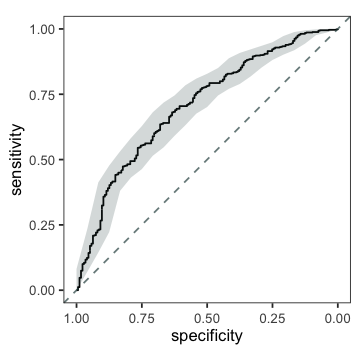

In [1410]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out)

plot(p)

In [1411]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [138]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.1962   102.00 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.1949   101.32 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.1961   101.94 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.1966   102.19 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.1968   102.29 |


In [139]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [140]:
summary(model) %>% print()


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6769  -0.9727   0.6244   0.7533   1.7199  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      6.7799125  1.6152166   4.198 2.70e-05 ***
mean_meanbp                     -0.0108197  0.0021622  -5.004 5.62e-07 ***
mean_resprate                    0.0137274  0.0065210   2.105 0.035283 *  
mean_heartrate                   0.0144375  0.0018545   7.785 6.97e-15 ***
mean_tempc                      -0.0847995  0.0370355  -2.290 0.022040 *  
mean_spo2                       -0.0372631  0.0083809  -4.446 8.74e-06 ***
mean_glucose                    -0.0010373  0.0005787  -1.793 0.073052 .  
first_careunitCSRU               0.0839756  0.1271044   0.661 0.508816    
first_careunitMICU              -0.3486573  0.1051489  -3.316 0.000914 ***
first_careunitS

In [141]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

In [144]:
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


In [145]:
oddsratio_categorical <- oddsratio  %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

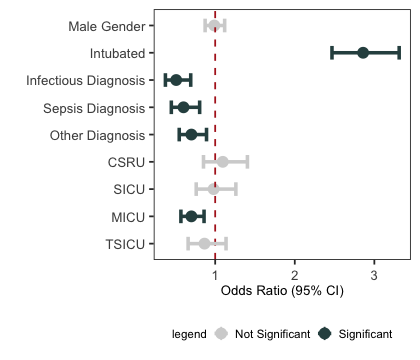

In [1417]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [1418]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [147]:
oddsratio_continuous <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

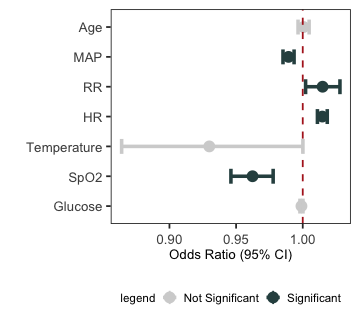

In [1419]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [1420]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

# LR Model for dopamine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [148]:
pressor_choice <- 'dopaminedurations'

In [149]:
model_input_df <- melt_results_df %>%
    filter(grepl(pressor_choice, pressor), INTERVAL == 1) %>% select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor))  %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
              contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              )

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [1423]:
dim(model_input_df) %>% print()

[1] 2790   12


In [1424]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [1428]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [1429]:
car::vif(model) %>% print()

                     GVIF Df GVIF^(1/(2*Df))
first_careunit   2.357441  4        1.113154
intub            1.509336  1        1.228551
simple_diagnosis 1.121208  3        1.019251
age_cohort       1.283326  1        1.132840
gender           1.374393  1        1.172345
mean_meanbp      1.134520  1        1.065139
mean_resprate    1.300793  1        1.140523
mean_heartrate   1.435470  1        1.198111
mean_tempc       1.074239  1        1.036455
mean_spo2        1.133670  1        1.064740
mean_glucose     1.227572  1        1.107959


In [1430]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.7805717,0.1453586,0.9007653,0.06182213


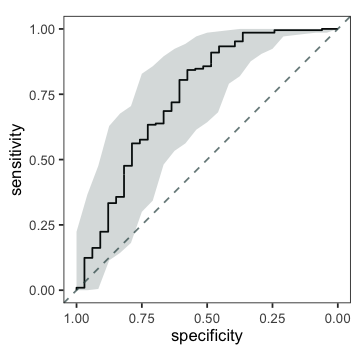

In [1431]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out)

plot(p)

In [1432]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [150]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2096   100.65 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2107   101.19 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2124   102.00 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |    0.213   102.30 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |    0.213   102.25 |


In [151]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [152]:
summary(model) %>% print()


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4967  -1.0140   0.5915   0.7549   1.9034  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      5.9866850  2.6249327   2.281   0.0226 *  
mean_meanbp                     -0.0149072  0.0034700  -4.296 1.74e-05 ***
mean_resprate                    0.0153909  0.0105284   1.462   0.1438    
mean_heartrate                   0.0157609  0.0029707   5.306 1.12e-07 ***
mean_tempc                      -0.1607589  0.0628121  -2.559   0.0105 *  
mean_spo2                       -0.0121466  0.0105315  -1.153   0.2488    
mean_glucose                    -0.0002420  0.0008522  -0.284   0.7764    
first_careunitCSRU               0.7435534  0.1817093   4.092 4.28e-05 ***
first_careunitMICU               0.2434468  0.1136680   2.142   0.0322 *  
first_careunitS

In [1436]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

In [153]:
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


In [154]:
oddsratio_categorical <- oddsratio %>% data.frame()  %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

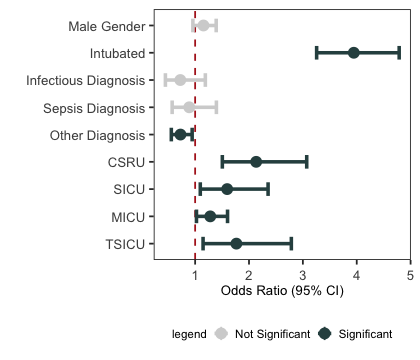

In [1438]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [1439]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [155]:
oddsratio_continuous <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

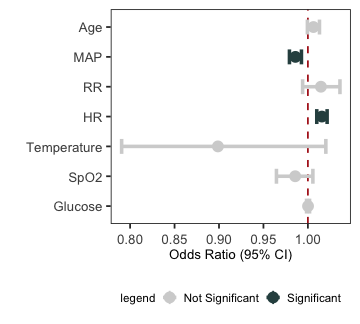

In [1440]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [1441]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

# LR Model for phenylephrine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [156]:
pressor_choice <- 'phenylephrinedurations'

In [157]:
model_input_df <- melt_results_df %>%
    filter(grepl(pressor_choice, pressor), INTERVAL == 1) %>% select(-pressor) %>%
    ungroup() %>%
    mutate(VARIABLE = ID, COURSE = course_id) %>%
    #mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(grepl(pressor_choice, pressor))  %>%
            select(-pressor) %>%
            select(RESPONSE, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -RESPONSE, -course_id) %>%
            rename(COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE) %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             intub,
             simple_diagnosis,
             age_cohort,
             gender,
              contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
             contains("mean_tempc"),
             contains("mean_spo2"),
             contains("mean_glucose")
              )

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [1497]:
dim(model_input_df) %>% print()

[1] 9384   12


In [1498]:
# exclude missing cases (done automatically by glm but this allows some more fine control)
model_input_cleaned_df <- model_input_df[which(complete.cases(model_input_df)),]

In [1513]:
options(repr.plot.width=3, repr.plot.height=3)
input <- model_input_cleaned_df
k <- 5
n <- dim(input)[1]
indices <- sample(rep(1:k, ceiling(n/k))[1:n])


all.acc <- all.response <- all.predictor <- aucs <- c()
for (i in 1:k) {
  test = input[indices==i,]
  learn = input[indices!=i,]
  model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=learn)
  model.pred <- predict(model, newdata=test)
  model.acc <- data.frame(PRED = model.pred > 0, RESPONSE = test$RESPONSE) %>% 
        summarize(ACC = sum(PRED == RESPONSE)/n()) %>% unlist()
  aucs <- c(aucs, roc(test$RESPONSE, model.pred)$auc)
  all.response <- c(all.response, test$RESPONSE)
  all.predictor <- c(all.predictor, model.pred)
  all.acc <- c(all.acc, model.acc)
}

p_out <- roc(all.response, all.predictor, grid=T, legacy.axes=T, ci=TRUE, auc=T)
#plot(p_out, print.auc=TRUE)

Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases
Setting levels: control = FALSE, case = TRUE
Setting direction: controls < cases


In [1514]:
car::vif(model) %>% print()

                     GVIF Df GVIF^(1/(2*Df))
first_careunit   1.596191  4        1.060195
intub            1.084010  1        1.041158
simple_diagnosis 1.244869  3        1.037180
age_cohort       1.104367  1        1.050889
gender           1.043890  1        1.021709
mean_meanbp      1.078996  1        1.038747
mean_resprate    1.355140  1        1.164105
mean_heartrate   1.241829  1        1.114374
mean_tempc       1.193189  1        1.092332
mean_spo2        1.185060  1        1.088605
mean_glucose     1.059904  1        1.029516


In [1515]:
lr_summary_list[[pressor_choice]] <- data.frame(MEAN_AUC = mean(aucs), 
                                         SD_AUC = sd(aucs), 
                                         MEAN_ACC = mean(all.acc), 
                                         SD_ACC = sd(all.acc))
lr_summary_list[[pressor_choice]] 

MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<dbl>,<dbl>,<dbl>,<dbl>
0.6542585,0.03637891,0.6189835,0.02898075


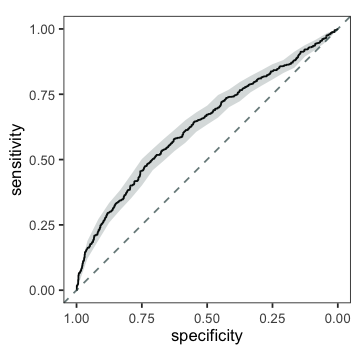

In [1502]:
options(repr.plot.width=3, repr.plot.height=3)
p <- roc_with_ci(p_out)

plot(p)

In [1503]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_modelauc.pdf")), 3,3)
plot(p)
dev.off()

pdf 
  2

In [158]:
# imputation: 30 mins
model_input_imputed_df <- 
    rfImpute(RESPONSE ~ . , family=binomial(link='logit'), data=model_input_df %>% select(contains("mean"), RESPONSE)) %>%
    cbind(model_input_df %>% select(-contains("mean"), -RESPONSE))

Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2429    97.72 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2444    98.33 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2445    98.37 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2458    98.88 |


Warning message in randomForest.default(xf, y, ntree = ntree, ..., do.trace = ntree, :
“The response has five or fewer unique values.  Are you sure you want to do regression?”

     |      Out-of-bag   |
Tree |      MSE  %Var(y) |
 300 |   0.2454    98.70 |


In [159]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_imputed_df)

In [160]:
summary(model) %>% print()


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_imputed_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6621  -1.0921   0.6005   1.1424   1.8363  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      6.5279149  1.3862070   4.709 2.49e-06 ***
mean_meanbp                     -0.0052147  0.0018174  -2.869 0.004113 ** 
mean_resprate                    0.0179088  0.0053195   3.367 0.000761 ***
mean_heartrate                   0.0113950  0.0015500   7.352 1.96e-13 ***
mean_tempc                      -0.1376723  0.0301729  -4.563 5.05e-06 ***
mean_spo2                       -0.0305182  0.0078409  -3.892 9.93e-05 ***
mean_glucose                     0.0021243  0.0005907   3.597 0.000322 ***
first_careunitCSRU              -0.8541878  0.0872366  -9.792  < 2e-16 ***
first_careunitMICU               0.1611542  0.1037728   1.553 0.120435    
first_careunitS

In [162]:
# isolate out model coefficients
summary(model)$coefficients %>% data.frame() %>% 
    tibble::rownames_to_column("Variable") %>%
    rename(P.Value = Pr...z..) %>% 
    mutate(SIGNIFICANT = P.Value < 0.05) %>% 
    write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_modelestimates.csv")))

In [161]:
oddsratio <- exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


In [163]:
oddsratio_categorical <- oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CATEGORICAL_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CATEGORICAL_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CATEGORICAL_COEFFICIENT_DICT)))

oddsratio_categorical %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodeleodds.csv")))

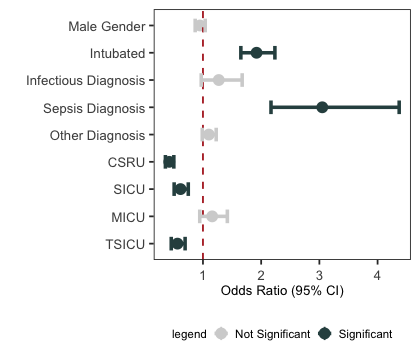

In [1509]:
options(repr.plot.width=3.5, repr.plot.height=3)
p <- oddsratio_categorical %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [1510]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_categoricalmodelodds.pdf")), 3.5,3)
plot(p)
dev.off()

pdf 
  2

In [164]:
oddsratio_continuous <-oddsratio %>% data.frame() %>%
    tibble::rownames_to_column("factor") %>%
    filter(factor != "(Intercept)") %>%
    rename(estimate = V1, lower = X2.5.., upper = X97.5..) %>%
    rowwise() %>%
    mutate(significant = (lower > 1 & upper > 1) | (lower < 1 & upper < 1)) %>%
    mutate(legend = if(significant){'Significant'}else{'Not Significant'}) %>%
    filter(factor %in% names(LR_CONTINUOUS_COEFFICIENT_DICT)) %>%
    mutate(factor = LR_CONTINUOUS_COEFFICIENT_DICT[factor]) %>%
    mutate(factor = factor(factor, levels= rev(LR_CONTINUOUS_COEFFICIENT_DICT)))

oddsratio_continuous %>% write.csv(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodeleodds.csv")))

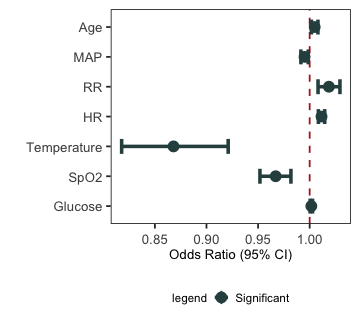

In [1511]:
options(repr.plot.width=3, repr.plot.height=2.7)
p <- oddsratio_continuous %>%
    ggplot(aes(x = factor,y = estimate, ymin = lower, ymax = upper ))+
        base_theme()+
        theme(legend.position="bottom")+
        geom_pointrange(aes(col=legend))+
        scale_color_manual(values=SIGNIFICANT_COLORS)+
        geom_hline(yintercept =1, linetype=2, color = "firebrick")+
        xlab('')+ ylab("Odds Ratio (95% CI)")+
        geom_errorbar(aes(ymin=lower, ymax=upper,col=legend),width=0.5,cex=1)+ 
        coord_flip()
plot(p)

In [1512]:
pdf(file.path(PLOT_DIR, paste0(pressor_choice, "_continuousmodelodds.pdf")), 3.1,2.7)
plot(p)
dev.off()

pdf 
  2

# Output AUC table

In [1516]:
auc_output_df <- bind_rows(lr_summary_list, .id="PRESSOR")
auc_output_df 

PRESSOR,MEAN_AUC,SD_AUC,MEAN_ACC,SD_ACC
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TOTAL,0.6603611,0.03198653,0.6432651,0.02660415
norepinephrinedurations,0.7205195,0.06787473,0.7775198,0.04533567
dopaminedurations,0.7805717,0.14535856,0.9007653,0.06182213
phenylephrinedurations,0.6542585,0.03637891,0.6189835,0.02898075


In [1517]:
auc_output_df  %>% write.csv(file.path(PLOT_DIR, "summary_auc.csv"))